In [114]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from scipy import stats
from sklearn import linear_model
from sklearn import preprocessing
from sklearn import model_selection
from sklearn import tree
from sklearn import ensemble
from sklearn import metrics
from sklearn import cluster
from sklearn import feature_selection
from sklearn.preprocessing import OneHotEncoder
from sklearn import linear_model, tree, ensemble, metrics, preprocessing 
from sklearn.model_selection \
    import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import SelectKBest, f_classif
import optuna
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import make_scorer
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import confusion_matrix
from sklearn.datasets import load_iris
from sklearn.ensemble import RandomForestClassifier


In [37]:
df=pd.read_csv('weatherAUS.csv')
df.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


In [38]:
df.isnull().sum().sum()

343248

In [39]:
round(df.isna().sum() / len(df), 3)
df.drop(['Evaporation','Sunshine','Cloud3pm'], axis = 1, inplace = True)

In [40]:
df.RainToday = df.RainToday.map({'No': 0, 'Yes': 1})
df.RainTomorrow = df.RainTomorrow.map({'No': 0, 'Yes': 1})

In [41]:
print(df['RainToday'].mean())

0.22419285648984874


In [42]:
# выделение признака Month
df['Month'] = pd.to_datetime(df['Date']).dt.month

# удаление признака Date
df = df.drop('Date', axis=1)

# рассчет доли дождливых дней для каждого месяца
df['RainyDays'] = (df['RainTomorrow'] == 'Yes').astype(int)
rainy_days_by_month = df.groupby('Month')['RainyDays'].mean()

# определение месяца с максимальной долей дождливых дней
max_rainy_month = rainy_days_by_month.idxmax()

print(max_rainy_month)

1


In [44]:
categoricals = ['Month', 'Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm']
df_dummies = pd.get_dummies(df, columns=categoricals)
df_dummies.shape

(145460, 125)

In [45]:
df_dummies.dropna(inplace=True)
X = df_dummies.drop('RainTomorrow', axis = 1)
Y = df_dummies['RainTomorrow']  
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state = 31)
Y_test.mean()

0.22770253002811142

In [46]:
def gbs(data, n):     
    inds = np.random.randint(0, len(data), (n, len(data))) #определяем индексы случайным образом
    numbers = data[inds] #выбираем значения по индексам
    return numbers
target = X_train['MinTemp'].values #выбираем целевую переменную
np.random.seed(31) #задаём параметр генератора случайных чисел
mean_values = [np.mean(x) for x in gbs(target, 1000)] #получаем все средние значения
np.std(mean_values) #находим для них стандартное отклонение

0.02879072820657669

In [51]:
clf = LogisticRegression()
clf.fit(X_train, Y_train)
preds_train = clf.predict(X_train)
preds_test = clf.predict(X_test)
roc_auc_score(Y_test, preds_test)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.7264629157966904

In [54]:
params = {
    'max_leaf_nodes': list(range(2, 10)), 
    'min_samples_split': [2, 3, 4], 
    'max_depth': [5,7,9,11]
}

grid_search_cv = GridSearchCV(DecisionTreeClassifier(random_state=42), params, verbose=3, cv=3)
grid_search_cv.fit(X_train, Y_train)
print(grid_search_cv.best_params_)

clf = DecisionTreeClassifier(max_depth = 5, max_leaf_nodes = 9, min_samples_split = 2, random_state=42)
clf.fit(X_train, Y_train)
preds_train = clf.predict(X_train)
preds_test = clf.predict(X_test)
print(round(roc_auc_score(Y_test, preds_test), 2))

Fitting 3 folds for each of 96 candidates, totalling 288 fits
[CV 1/3] END max_depth=5, max_leaf_nodes=2, min_samples_split=2;, score=0.817 total time=   0.2s
[CV 2/3] END max_depth=5, max_leaf_nodes=2, min_samples_split=2;, score=0.820 total time=   0.2s
[CV 3/3] END max_depth=5, max_leaf_nodes=2, min_samples_split=2;, score=0.825 total time=   0.3s
[CV 1/3] END max_depth=5, max_leaf_nodes=2, min_samples_split=3;, score=0.817 total time=   0.2s
[CV 2/3] END max_depth=5, max_leaf_nodes=2, min_samples_split=3;, score=0.820 total time=   0.3s
[CV 3/3] END max_depth=5, max_leaf_nodes=2, min_samples_split=3;, score=0.825 total time=   0.3s
[CV 1/3] END max_depth=5, max_leaf_nodes=2, min_samples_split=4;, score=0.817 total time=   0.3s
[CV 2/3] END max_depth=5, max_leaf_nodes=2, min_samples_split=4;, score=0.820 total time=   0.2s
[CV 3/3] END max_depth=5, max_leaf_nodes=2, min_samples_split=4;, score=0.825 total time=   0.2s
[CV 1/3] END max_depth=5, max_leaf_nodes=3, min_samples_split=2;,

In [56]:
clf = RandomForestClassifier(n_estimators = 100, random_state=31)
clf.fit(X_train, Y_train)
preds_train = clf.predict(X_train)
preds_test = clf.predict(X_test)
print(round(roc_auc_score(Y_test, preds_test), 2))

0.73


In [57]:
params = {
    'max_features': [4, 5, 6, 7], 
    'min_samples_leaf': [3, 5, 7, 9, 11], 
    'max_depth': [5, 10, 15]
}
grid_search_cv = GridSearchCV(RandomForestClassifier(random_state=31), params, verbose=3, cv=3)
grid_search_cv.fit(X_train, Y_train)
print(grid_search_cv.best_params_)
clf = RandomForestClassifier(max_depth=15, max_features=7, min_samples_leaf=3, random_state=31)
clf.fit(X_train, Y_train)
preds_train = clf.predict(X_train)
preds_test = clf.predict(X_test)
print(round(roc_auc_score(Y_test, preds_test), 2))

Fitting 3 folds for each of 60 candidates, totalling 180 fits
[CV 1/3] END max_depth=5, max_features=4, min_samples_leaf=3;, score=0.774 total time=   2.1s
[CV 2/3] END max_depth=5, max_features=4, min_samples_leaf=3;, score=0.773 total time=   1.6s
[CV 3/3] END max_depth=5, max_features=4, min_samples_leaf=3;, score=0.773 total time=   1.5s
[CV 1/3] END max_depth=5, max_features=4, min_samples_leaf=5;, score=0.773 total time=   1.9s
[CV 2/3] END max_depth=5, max_features=4, min_samples_leaf=5;, score=0.773 total time=   1.7s
[CV 3/3] END max_depth=5, max_features=4, min_samples_leaf=5;, score=0.773 total time=   1.8s
[CV 1/3] END max_depth=5, max_features=4, min_samples_leaf=7;, score=0.773 total time=   1.5s
[CV 2/3] END max_depth=5, max_features=4, min_samples_leaf=7;, score=0.773 total time=   1.6s
[CV 3/3] END max_depth=5, max_features=4, min_samples_leaf=7;, score=0.773 total time=   1.5s
[CV 1/3] END max_depth=5, max_features=4, min_samples_leaf=9;, score=0.773 total time=   1.4

In [58]:
feature_names = [x for x in df_dummies if x != 'RainTomorrow']
pd.DataFrame({'feat': feature_names,
              'coef': clf.feature_importances_}).sort_values(by='coef', ascending=False)

,feat,coef
7,Humidity3pm,0.254969
2,Rainfall,0.085887
10,Cloud9am,0.069140
9,Pressure3pm,0.066072
13,RainToday,0.063289
...,...,...
63,Location_SalmonGums,0.000000
39,Location_Dartmoor,0.000000
73,Location_Witchcliffe,0.000000
51,Location_Newcastle,0.000000


# Бустинг 

In [68]:
df=pd.read_csv('AirPass.csv')
df = df.drop(df.columns[0], axis=1)
df.head()

,id,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,...,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,70172,Male,Loyal Customer,13,Personal Travel,Eco Plus,460,3,4,3,...,5,4,3,4,4,5,5,25,18.0,neutral or dissatisfied
1,5047,Male,disloyal Customer,25,Business travel,Business,235,3,2,3,...,1,1,5,3,1,4,1,1,6.0,neutral or dissatisfied
2,110028,Female,Loyal Customer,26,Business travel,Business,1142,2,2,2,...,5,4,3,4,4,4,5,0,0.0,satisfied
3,24026,Female,Loyal Customer,25,Business travel,Business,562,2,5,5,...,2,2,5,3,1,4,2,11,9.0,neutral or dissatisfied
4,119299,Male,Loyal Customer,61,Business travel,Business,214,3,3,3,...,3,3,4,4,3,3,3,0,0.0,satisfied


In [69]:
df.isnull().sum().sum()

310

In [70]:
df['Arrival Delay in Minutes'] = df['Arrival Delay in Minutes'].fillna(df['Arrival Delay in Minutes'].median())
df['Arrival Delay in Minutes'].mean()

15.133392362180475

In [72]:
print(df.groupby('Gender')['satisfaction'].value_counts()*100/df.shape[0])

print(df.groupby('Type of Travel')['satisfaction'].value_counts()*100/df.shape[0])

print(df.groupby('Class')['satisfaction'].value_counts()*100/df.shape[0])

Gender  satisfaction           
Female  neutral or dissatisfied    29.058554
        satisfied                  21.687327
Male    neutral or dissatisfied    27.608177
        satisfied                  21.645942
Name: count, dtype: float64
Type of Travel   satisfaction           
Business travel  satisfied                  40.177472
                 neutral or dissatisfied    28.785225
Personal Travel  neutral or dissatisfied    27.881506
                 satisfied                   3.155798
Name: count, dtype: float64
Class     satisfaction           
Business  satisfied                  33.184478
          neutral or dissatisfied    14.614452
Eco       neutral or dissatisfied    36.614567
          satisfied                   8.374076
Eco Plus  neutral or dissatisfied     5.437712
          satisfied                   1.774715
Name: count, dtype: float64


In [73]:
df['satisfaction'] = df['satisfaction'].map({'neutral or dissatisfied':0 , 'satisfied':1})
df['Customer Type'] = df['Customer Type'].map({'Loyal Customer':1, 'disloyal Customer':0})
df['Type of Travel'] = df['Type of Travel'].map({'Personal Travel':0, 'Business travel':1})
df['Gender'] = df['Gender'].map({'Male': 0, 'Female': 1})

In [74]:
df=pd.get_dummies(df)
df.shape

(103904, 26)

In [82]:
X=df.drop('satisfaction', axis=1)
y=df['satisfaction']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=26)
y_test.shape

(20781,)

In [84]:
scaler = StandardScaler()
scaler.fit(X_train) 
X_train = scaler.transform(X_train) 
X_test = scaler.transform(X_test) 
X_test[0][0]

0.9408251379303

In [87]:
model_lr = LogisticRegression()
model_lr.fit(X_train, y_train)
preds_test = model_lr.predict(X_test)
f1_score(preds_test, y_test)

0.8546883773161146

In [89]:
model_ada = AdaBoostClassifier(DecisionTreeClassifier(random_state=26),random_state=26,learning_rate=0.01)

model_ada.fit(X_train, y_train)
preds_test = model_ada.predict(X_test)
f1_score(preds_test, y_test)

0.9404794558121674

In [93]:
model_for_gs = GradientBoostingClassifier()
params = {"n_estimators":2**np.arange(8), "learning_rate":0.1**np.arange(3)}
gs = GridSearchCV(model_for_gs, 
                  params, 
                  cv=3, 
                  scoring=make_scorer(f1_score),
                  verbose=5)
 
gs.fit(X_train, y_train)
 
print("Лучшие гиперпараметры:", gs.best_params_)
print("Лучшее значение метрики:", gs.best_score_)

Fitting 3 folds for each of 24 candidates, totalling 72 fits
[CV 1/3] END .learning_rate=1.0, n_estimators=1;, score=0.873 total time=   0.4s
[CV 2/3] END .learning_rate=1.0, n_estimators=1;, score=0.870 total time=   0.3s
[CV 3/3] END .learning_rate=1.0, n_estimators=1;, score=0.871 total time=   0.3s
[CV 1/3] END .learning_rate=1.0, n_estimators=2;, score=0.880 total time=   0.6s
[CV 2/3] END .learning_rate=1.0, n_estimators=2;, score=0.878 total time=   0.5s
[CV 3/3] END .learning_rate=1.0, n_estimators=2;, score=0.875 total time=   0.4s
[CV 1/3] END .learning_rate=1.0, n_estimators=4;, score=0.901 total time=   0.8s
[CV 2/3] END .learning_rate=1.0, n_estimators=4;, score=0.896 total time=   0.8s
[CV 3/3] END .learning_rate=1.0, n_estimators=4;, score=0.897 total time=   0.8s
[CV 1/3] END .learning_rate=1.0, n_estimators=8;, score=0.920 total time=   1.6s
[CV 2/3] END .learning_rate=1.0, n_estimators=8;, score=0.920 total time=   1.7s
[CV 3/3] END .learning_rate=1.0, n_estimators=8;

In [95]:
model_xgb = XGBClassifier(random_state=26)
model_xgb.fit(X_train,y_train)
preds_test = model_xgb.predict(X_test)
f1_score(preds_test, y_test)

0.9579785161685312

In [97]:
model = CatBoostClassifier(random_state=26)
model.fit(X_train, y_train)
preds_class = model.predict(X_test)
f1_score(preds_class, y_test)

Learning rate set to 0.068023
0:	learn: 0.6018254	total: 163ms	remaining: 2m 43s
1:	learn: 0.5020788	total: 256ms	remaining: 2m 7s
2:	learn: 0.4472506	total: 360ms	remaining: 1m 59s
3:	learn: 0.4028683	total: 432ms	remaining: 1m 47s
4:	learn: 0.3674742	total: 484ms	remaining: 1m 36s
5:	learn: 0.3397838	total: 525ms	remaining: 1m 27s
6:	learn: 0.3121236	total: 555ms	remaining: 1m 18s
7:	learn: 0.2917493	total: 607ms	remaining: 1m 15s
8:	learn: 0.2749031	total: 656ms	remaining: 1m 12s
9:	learn: 0.2575194	total: 713ms	remaining: 1m 10s
10:	learn: 0.2473688	total: 760ms	remaining: 1m 8s
11:	learn: 0.2377536	total: 792ms	remaining: 1m 5s
12:	learn: 0.2279307	total: 817ms	remaining: 1m 2s
13:	learn: 0.2212511	total: 841ms	remaining: 59.2s
14:	learn: 0.2100355	total: 863ms	remaining: 56.7s
15:	learn: 0.2025734	total: 912ms	remaining: 56.1s
16:	learn: 0.1942301	total: 939ms	remaining: 54.3s
17:	learn: 0.1877938	total: 962ms	remaining: 52.5s
18:	learn: 0.1832382	total: 994ms	remaining: 51.3s
19

0.9598221728257851

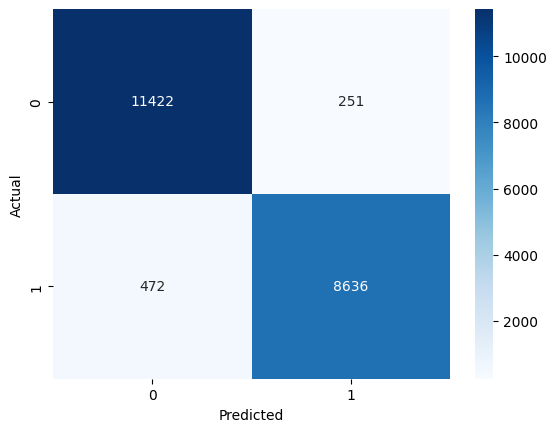

In [104]:
y_pred = model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt=".0f", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [122]:
import math
def euclidean_distance(x1, x2, y1, y2):
    return math.sqrt((x1-x2)**2 + (y1-y2)**2)

#Здесь функция `euclidean_distance` принимает четыре аргумента: координаты первой точки `x1`, `y1`, координаты второй точки `x2`, `y2`. Функция возвращает евклидово расстояние между этими точками.
#Для применения этой функции к нашим точкам `A(2,3)` и `B(5,-1)` можно написать следующий код:
x1 = 2
y1 = 3
x2 = 5
y2 = -1
distance = euclidean_distance(x1,x2,y1,y2)
print(distance)

5.0
